##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bildklassifikation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/SchuelerUniTUBAF2024/blob/main/02_Bild_Klassifizierung.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/SchuelerUniTUBAF2024/blob/main/02_Bild_Klassifizierung.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In diesem Tutorial werden Blumenbilder klassifiziert.

Es folgt den grundlegenden Machine Learning Schritten:

1. Daten betrachten und verstehen
2. Eingabe Pipeline erstellen
3. Model bauen
4. Model trainieren
5. Model testen
6. Model verbessern und den Prozess wiederholen

## Import TensorFlow und benötigte Bibliotheken

In [22]:
# Unterdrücken von C++ Tensorflow Logs
# Use at your Own Risk!
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

2025-08-01 12:36:57.191573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 12:36:57.204447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 12:36:57.209046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 12:36:57.219002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset downloaden und kennenlernen

Dieses Tutorial nutzt ein Dataset mit ca. 3,700 Fotos von Blumen. Das Datenset besteht aus fünf Unterverzeichnissen pro Klasse:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Jetzt steht eine Kopie des Datasets zur Verfügung. Insgesamt gibt es 3,670 Bilder:

In [20]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Hier einige Rosen:

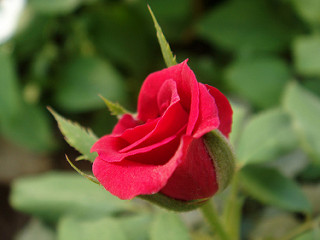

In [21]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### Aufgabe
Schaut in jedes der Unterverzeichnisse und schaut euch ein paar der Blumenbilder an.
Nutzt dazu untenstehenden Code.  

Die Unterverzeichnisse sind:
```
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```
Der Index der Liste gibt das entsprechende Bild an.

Fällt euch was auf?


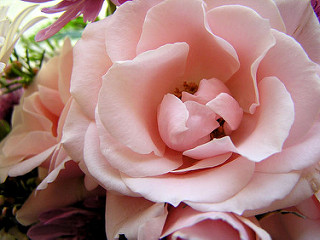

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[-1]))

# Laden der Daten mit Keras

Die Bilder müssen von der Festplatte geladen werden. Dabei hilft die `tf.keras.utils.image_dataset_from_directory` Methode.
Dies erzeugt aus einem Verzeichnis voller Bilder ein `tf.data.Dataset` mit wenigen Codezeilen.

## Datenset anlegen

Parameter:

In [3]:
batch_size = 32
img_height = 180
img_width = 180

80% der Bilder sollten für Training genutzt werden und die restlichen 20% zur Validierung.

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7340 files belonging to 6 classes.
Using 5872 files for training.


I0000 00:00:1754044625.968961  165393 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754044626.014489  165393 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754044626.018906  165393 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754044626.022122  165393 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7340 files belonging to 6 classes.
Using 1468 files for validation.


Die Klassenbezeichner finden sich im `class_names` attribute des Datensets. Diese entsprechen den Unterverzeichnisnamen .

In [6]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'flower_photos', 'roses', 'sunflowers', 'tulips']


## Daten anzeigen

Hier die ersten neun Bilder der Datensets.

2025-08-01 12:37:14.010108: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


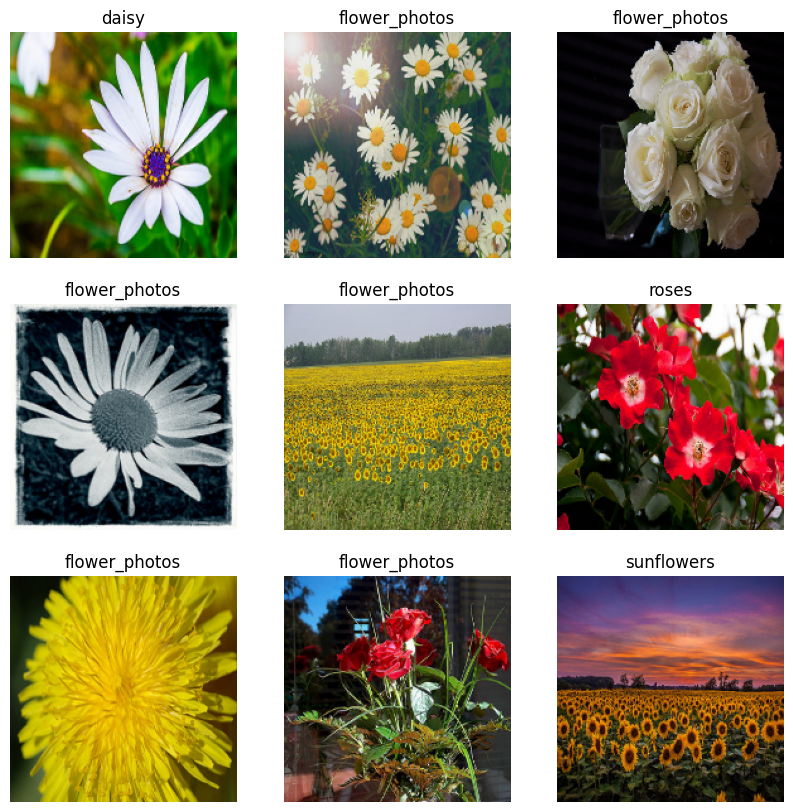

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Performance des Datensets anpassen

Die Puffergrössen müssen angepaßt werden um ein schnelles Laden zu gewährleisten.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardisierung der Daten

Die Rot/Grün/Blau Kanäle der Bilder sind im Bereich von `[0, 255]`.
Das ist nicht ideal für ein Neuronales Netzwerk. Für dieses sollte der Input klein sein.

Wir werden die Werte standardisieren auf einen Interval von `[0, 1]` mittels der Methode `tf.keras.layers.Rescaling`:

In [9]:
normalization_layer = layers.Rescaling(1./255)

Es gibt zwei Möglichkeiten diesen Layer anzuwenden. Wir können ihn direkt auf die Daten anwenden mit `Dataset.map`.

Oder wir können ihn in unser Model einbauen, was wir weiter unten tun werden.

# Create the model

The [Sequential](../../guide/keras/sequential_model.ipynb) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

## Convolutions

> unfortunately microscope is not working anymore ;(

[Ein Blick in die Netze](https://microscope.openai.com/models)


In [10]:
num_classes = 6

model = Sequential([
  layers.Input([img_height, img_width, 3]),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren des Models



In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Übersicht

Mit der `Model.summary` Methode können wir uns alle Layer des Models anschauen:

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Training des Models

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1754044666.345772  165480 service.cc:146] XLA service 0x789190005570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754044666.345804  165480 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-08-01 12:37:46.367937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-01 12:37:46.469777: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 17/184 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3260 - loss: 2.7187

I0000 00:00:1754044668.995776  165480 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.4631 - loss: 1.6926 - val_accuracy: 0.4959 - val_loss: 1.2459
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4897 - loss: 1.2592 - val_accuracy: 0.4939 - val_loss: 1.2400
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4811 - loss: 1.1901 - val_accuracy: 0.4516 - val_loss: 1.2190
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5015 - loss: 1.1078 - val_accuracy: 0.4053 - val_loss: 1.2215
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5063 - loss: 1.0367 - val_accuracy: 0.3896 - val_loss: 1.2371
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4915 - loss: 0.9645 - val_accuracy: 0.3515 - val_loss: 1.2752
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5008 - loss: 0.9057 - val_accuracy: 0.2779 - val_loss: 1.4088
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5131 - loss: 0.8600 - val_accuracy: 0.24

## Anzeigen der Trainingsresultate

Erstellen eines Diagramms auf dem Trainingsset und dem Validierungsset:

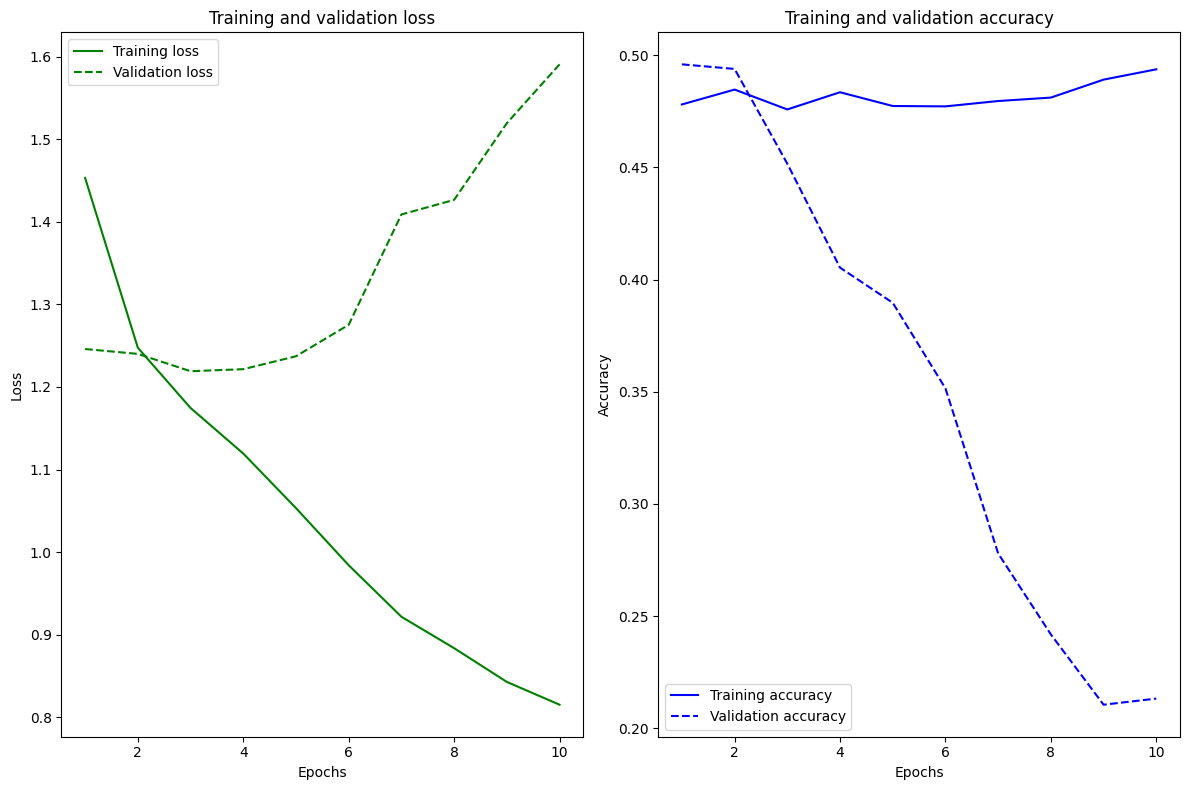

In [13]:
import matplotlib.pyplot as plt

def plot_acc_val(history_dict):

    def plot_subplot(type, axis, color, train, val):
        axis.plot(epochs, train, '%s'%color, label='Training %s'%type)
        axis.plot(epochs, val, '%s--'%color, label='Validation %s'%type)
        axis.set_title("Training and validation %s"%type)
        axis.set_xlabel('Epochs')
        axis.set_ylabel(type.capitalize())
        axis.legend()
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict.get('accuracy', history_dict.get('acc'))
    val_accuracy = history_dict.get('val_accuracy', history_dict.get('val_acc'))
    epochs = range(1, len(loss) + 1)

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Plotting the training and validation loss
    plot_subplot('loss', ax1, 'g', loss, val_loss)

    # Plotting the training and validation accuracy
    if accuracy is not None and val_accuracy is not None:
        plot_subplot('accuracy', ax2, 'b', accuracy, val_accuracy)

    plt.tight_layout()
    plt.show()

plot_acc_val(history.history)


Die Plots zeigen dass die Trainingsgenauigkeit und die Validierungsgenauigkeit sich um Größeneinheiten unterscheiden. Und die Genauigkeit des Modells liegt lediglich bei 60%.

Was ist also schief gelaufen und was können wir dagegen tun?

## Overfitting

Im obigen Diagramm wächst die Trainingsgenauigkeit Linear, aber die Validierungsgenauigkeit bricht bei ca. 60% ab.
Ebenso ist die Differenz zwischen Training und Validierung sehr groß. Dies ist ein Zeichen für [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Bei kleinen Mengen an Trainingsbeispielen lernen die Modelle manchmal unerwünschte Details oder Hintergrundrauschen der Trainingsbilder. Wenn dies zuviel passiert hat das einen negativen Einfluss auf die Performance.
Diese Overfitting bedeutet das das Model Schwierigkeiten hat sich auf ein neues Dataset zu Generalisieren.

Wir werden hier *data augmentation* nutzen und *Dropout* Layer zeigen.

## Data augmentation

Overfitting passiert generell when es zu wenige Trainingsbilder gibt.
Mit Data Augmentation werden aus alten Bildern neue Bilder generiert die geringfügig verändert werden um so in Summe aus wenigen Bildern mehr zu machen.

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/vgoehler/Applications/anaconda3/envs/usegpu/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Schauen wir uns einige der neuen Bilder an:

2025-08-01 12:38:35.498856: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


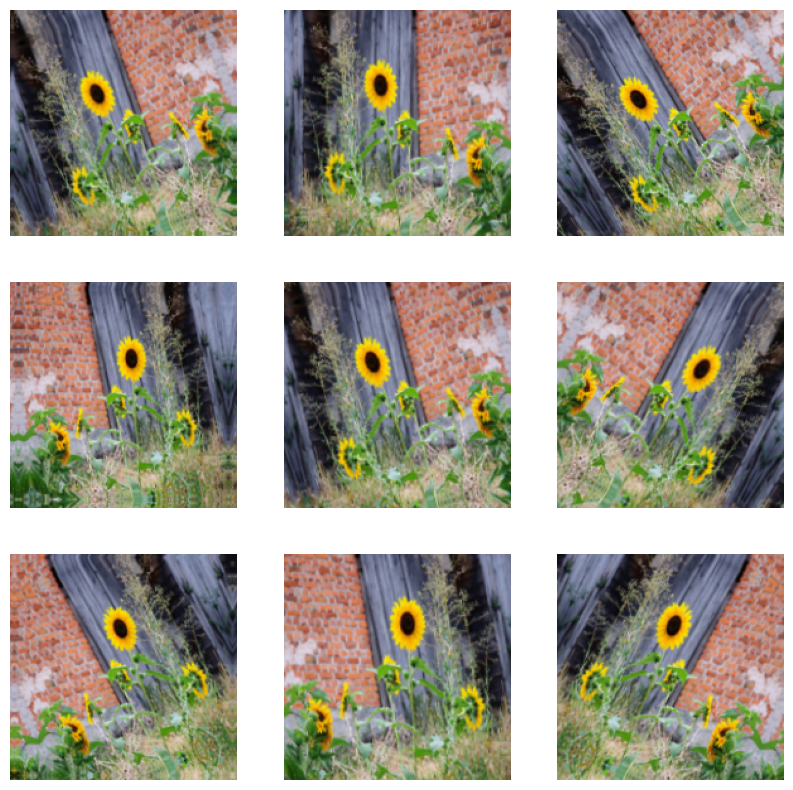

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Eine andere Technik um Overfitting zu vermeiden ist der [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) im Netzwerk.

Ein Dropoutlayer läßt zufällig einige Eingabe aus der Verarbeitung im Netzwerk fallen (die Aktivierung wird auf 0 gesetzt).
Bei dem Dropoutlayer kann man mit Kommazahlen die Prozentanzahl an ignorierten Eingaben einstellen (0.1=10% etc.).

Wir erzeugen jetzt ein neues Netzwerk mit  `tf.keras.layers.Dropout` Layern und werden das dann mit unseren data augmented Eingaben trainieren:

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren und trainieren des Models

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 10
history_imp = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2025-08-01 12:38:49.720135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
W0000 00:00:1754044730.060037  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044730.086453  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044730.087528  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044730.088504  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044730.089312  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044730.090362  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement

  4/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3177 - loss: 2.7911

W0000 00:00:1754044731.153615  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.154928  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.157699  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.164872  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.173545  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.181624  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.182701  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.183773  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044731.185177  165476 gp

173/184 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4702 - loss: 1.6254

W0000 00:00:1754044733.436855  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.437552  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.438228  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.438898  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.439505  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.440123  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.440728  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.441729  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.442738  165478 gp

179/184 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4707 - loss: 1.6190

W0000 00:00:1754044733.885613  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.886636  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.888284  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.891985  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.898372  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.899272  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.900088  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.900927  165478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044733.901848  165478 gp

183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4711 - loss: 1.6149

W0000 00:00:1754044734.395684  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.396560  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.397388  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.398191  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.398917  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.399626  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.400329  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.401716  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.403119  165476 gp

184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4712 - loss: 1.6129 - val_accuracy: 0.5068 - val_loss: 1.2575
Epoch 2/10
 10/184 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4996 - loss: 1.2623

W0000 00:00:1754044734.596448  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.597511  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.598298  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.599110  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.599953  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.600791  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.601566  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.610099  165476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754044734.611096  165476 gp

184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4896 - loss: 1.2654 - val_accuracy: 0.4864 - val_loss: 1.1970
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4722 - loss: 1.2243 - val_accuracy: 0.4966 - val_loss: 1.1844
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4798 - loss: 1.1816 - val_accuracy: 0.4939 - val_loss: 1.1421
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4806 - loss: 1.1666 - val_accuracy: 0.4632 - val_loss: 1.1700
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5017 - loss: 1.1237 - val_accuracy: 0.4578 - val_loss: 1.1193
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4883 - loss: 1.1079 - val_accuracy: 0.4871 - val_loss: 1.1313
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4951 - loss: 1.0897 - val_accuracy: 0.4448 - val_loss: 1.1359
Epoch 9/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4921 - loss: 1.0647 - val_accuracy: 0.459

## Anzeigen der Trainingsergebnisse

Nachdem wir die Data Augmentation und den `tf.keras.layers.Dropout` Layer eingesetzt haben ist weniger overfitting als vorher zu erkennen. Ebenso ist die Genauigkeit des Trainings und des Validierungsdataset näher bei einander.

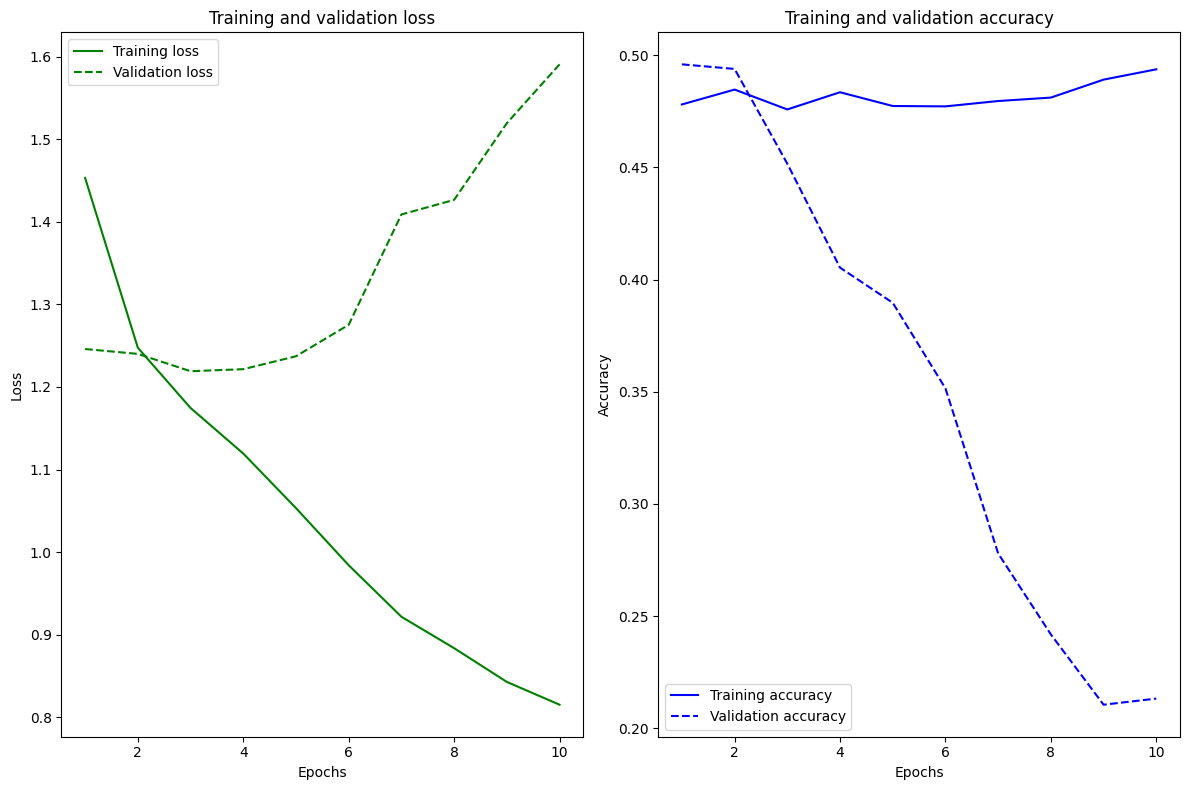

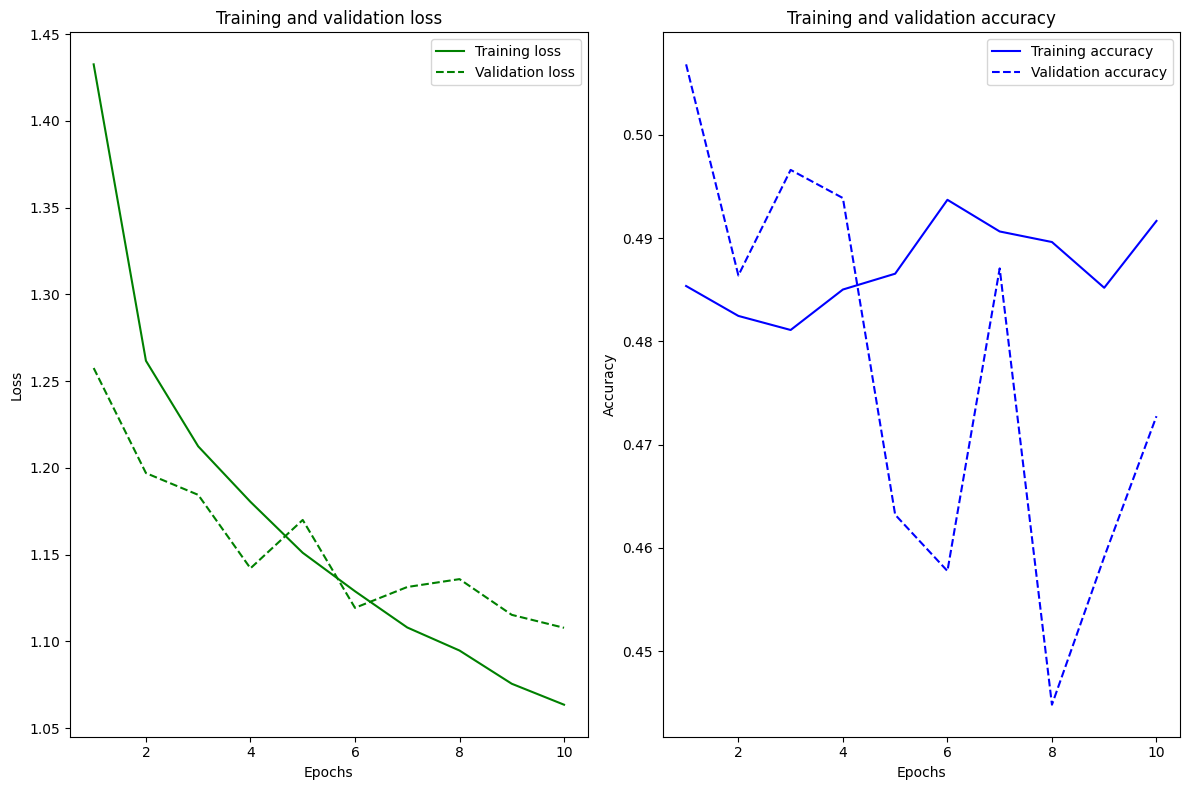

In [20]:
plot_acc_val(history.history)
plot_acc_val(history_imp.history)

## Vorhersage auf neuen Daten

Schlußendlich werden wir unser Model auf neuen Daten anwenden die nicht im Trainings oder Validierungs Set enthalten waren.
![](https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg)

In [23]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Dieses Bild gehört zu {} mit {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Dieses Bild gehört zu flower_photos mit 47.72 %.


### Experiment

Nutze untenstehenden Code um das Model anzupassen.
Wie hoch kannst du die Genauigkeit heben?  
  
Passe an:

- Data Augmentation (mögliche Funktionen werden weiter unten gezeigt)
- Parameter des Netzes
    - Layer (weitere hinzufügen, auch DropOut)
    - DropOut Parameter zwischen 0 und 1
    - Aktivierungsfunktion (relu, gelu, selu, sigmoid, etc.)
    - Layer Initializierung (he_normal, he_uniform, glorot_uniform, glorot_normal, random_normal)
    - Anzahl der Neuronen
    - Optimizers (adam, nadam, sgd)
---

#### Data Augmentation
Out of the `tf.keras.layers` package  

#### [RandomCrop](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_crop/) layer
mandatory:
- height
- width
#### [RandomFlip](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/) layer
- optional:
- mode [horizontal", "vertical", or "horizontal_and_vertical"]
#### [RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_translation/) layer
mandatory:
- height_factor
- width_factor
optional:
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomRotation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/) layer
mandatory:
- factor
optional:
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/) layer
mandatory:
- height_factor
optional:
- width_factor
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomContrast](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_contrast/) layer
mandatory:
- factor
#### [RandomBrightness](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_brightness/) layer
mandatory:
- factor

Epoch 1/10
92/92 [==============================] - 21s 218ms/step - loss: 1.7461 - accuracy: 0.4520 - val_loss: 1.2909 - val_accuracy: 0.4837
Epoch 2/10
92/92 [==============================] - 19s 210ms/step - loss: 1.0441 - accuracy: 0.5811 - val_loss: 0.9878 - val_accuracy: 0.6213
Epoch 3/10
92/92 [==============================] - 19s 205ms/step - loss: 0.9575 - accuracy: 0.6287 - val_loss: 0.8990 - val_accuracy: 0.6594
Epoch 4/10
92/92 [==============================] - 19s 205ms/step - loss: 0.8763 - accuracy: 0.6584 - val_loss: 0.8359 - val_accuracy: 0.6826
Epoch 5/10
92/92 [==============================] - 19s 205ms/step - loss: 0.8058 - accuracy: 0.6860 - val_loss: 0.9005 - val_accuracy: 0.6771
Epoch 6/10
92/92 [==============================] - 19s 205ms/step - loss: 0.7777 - accuracy: 0.6979 - val_loss: 0.8175 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 20s 215ms/step - loss: 0.7177 - accuracy: 0.7197 - val_loss: 0.7980 - val_accuracy: 0.6975

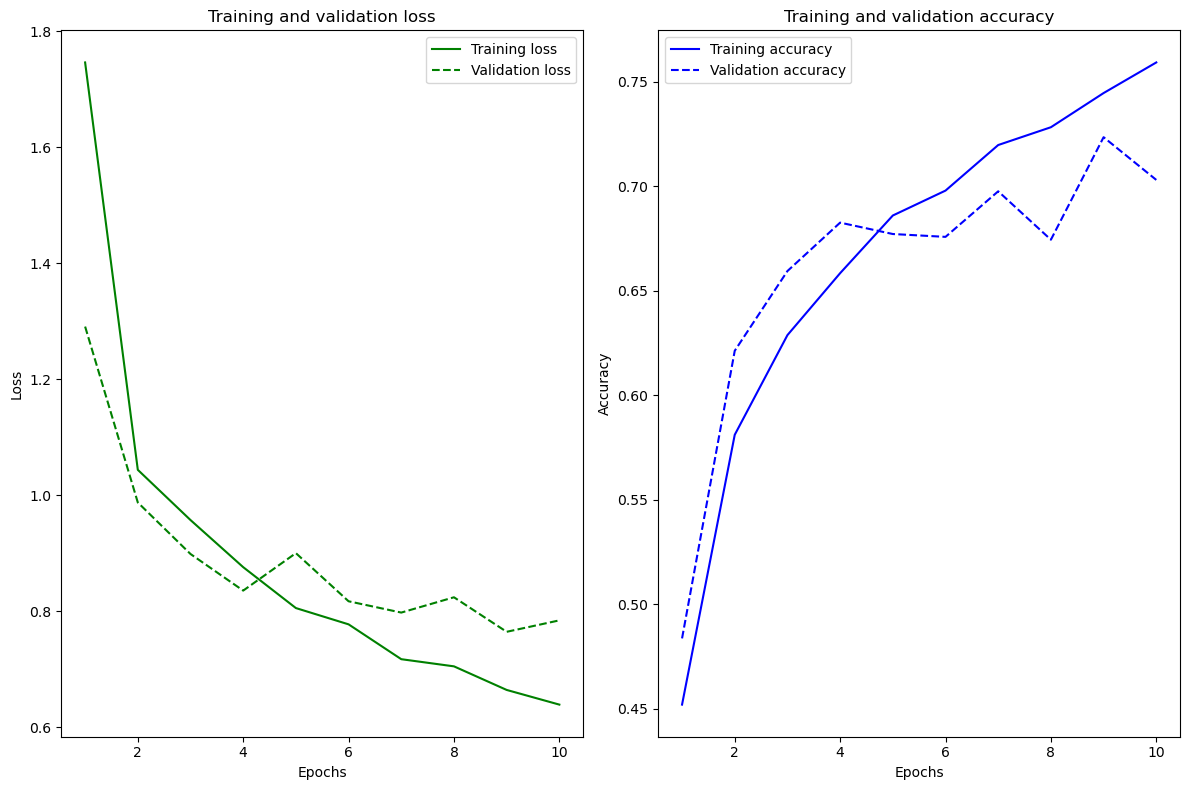

In [27]:
# RESET
tf.keras.backend.clear_session()


model_exp = Sequential([
    # data augmentation part
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # normalization
    layers.Rescaling(1./255),
    # Neural Net
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    # Entscheidungsebene
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # letzen Layer nicht ändern, brauchen wir !
    layers.Dense(num_classes)
])


model_exp.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history_exp = model_exp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

plot_acc_val(history_exp.history)